In [36]:
import os, sys, time, random, json, pickle, itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
random.seed(12345678)
np.random.seed(12345678)

In [37]:
import torch, torchvision
from sklearn.preprocessing import MinMaxScaler
print('Current CUDA device:', torch.cuda.get_device_name(0))
torch.cuda.set_device(0)

Current CUDA device: NVIDIA GeForce RTX 2080 Ti


In [38]:
# Define data files
datadir = 'telecom-tn/'
datafn_tmpl = datadir + 'sms-call-internet-mi-%4d-%02d-%02d.txt'
datafn_idxs = [ (2013, 11, i) for i in range(1, 31) ] # + [ (2013, 12, i) for i in range(1, 32) ] + [ (2014, 1, 1) ]
datafns = [ datafn_tmpl % x for x in datafn_idxs ]
print("Number of non-existent files:", sum([ not os.path.exists(fn) for fn in datafns ]))
outfn = datadir[:-1] + '-internet.csv'

Number of non-existent files: 0


In [39]:
# Pick the data files to index
fns = datafns#[:10]

## Read and Preprocess Data (Save to CSV)

In [40]:
# data = pd.DataFrame()
# for fn in fns:
#     print('Reading file ', fn, ' ...')
#     df = pd.read_csv(fn, sep="\t", header=None, names=['grid', 'time', 'country', 'sms-in', 'sms-out', 'call-in', 'call-out', 'internet'])
#     df = df[ df['country'] == 39 ].drop(columns=['country', 'sms-in', 'sms-out', 'call-in', 'call-out']).fillna(0)
#     data = pd.concat([ data, df ])
# data = data.sort_values(by=['time', 'grid']).reset_index(drop=True)

In [41]:
# # Statistics of the dataset
# print("# 10min slots:", len(data['time'].unique()) )
# print("Mean internet:", data['internet'].mean())
# print("(Min, 5%, 25%, median, 75%, 95%, max) internet:")
# print( ( data['internet'].min(), data['internet'].quantile(0.05), data['internet'].quantile(0.25), data['internet'].median(), data['internet'].quantile(0.75), data['internet'].quantile(0.95), data['internet'].max() )  )

In [42]:
# data.to_csv(outfn)

## Load Data

In [43]:
data = pd.read_csv(outfn, index_col=0)
print("# 10min slots:", len(data['time'].unique()) )

# 10min slots: 4320


In [44]:
# Find a grid with the maximum total demand for the prediction task
max_dmd_grid = sorted([ ( data[ data['grid']==i ]['internet'].sum(), i ) for i in range(1, 10001) ])
max_dmd_grid = list(reversed(max_dmd_grid))
gridx = max_dmd_grid[0][1]
max_dmd_grid[:30]

[(6225726.724344607, 5161),
 (5774323.036540795, 5059),
 (5715712.825371909, 5259),
 (4948019.090107161, 4459),
 (4921204.364796819, 5061),
 (4867853.564490444, 5258),
 (4651214.922853503, 4855),
 (4599559.134254118, 5758),
 (4551334.489298275, 5159),
 (4535011.137059767, 4856),
 (4533058.0628793575, 6064),
 (4496689.3141231965, 4956),
 (4379979.920228866, 6058),
 (4202262.124469364, 5857),
 (4146716.5510001173, 5262),
 (3942925.345984585, 4955),
 (3932214.9481866406, 4857),
 (3921889.412150063, 5256),
 (3867017.0575550864, 4961),
 (3834695.0400703857, 4755),
 (3778908.5965961814, 5162),
 (3773799.026719639, 5567),
 (3754625.576074761, 5955),
 (3729976.3995563453, 5458),
 (3704099.6945424797, 6169),
 (3604593.7459866023, 5461),
 (3580782.3053276436, 5163),
 (3575569.9936744645, 5263),
 (3572812.9917282173, 6065),
 (3541086.706635071, 5261)]

In [45]:
datax = data[ data['grid'] == gridx ].reset_index(drop=True)

<AxesSubplot:>

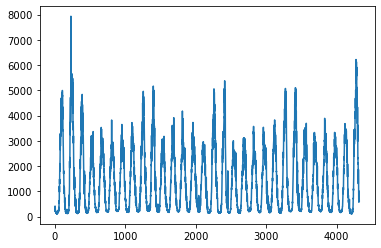

In [46]:
# Plot the data
datax['internet'].plot()

## Learning and Prediction

---
---
---

### 1. LSTM single grid prediction

**Preparing data.**

In [143]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 2880 Test size: 1440


In [144]:
# Train/test split
x = datax['internet'].to_numpy()
train = x[:train_size]
test = x[train_size:]

In [145]:
# Normalized training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train.reshape(-1, 1))
train_normalized = torch.FloatTensor(train_normalized).view(-1)
train_normalized

tensor([-0.9312, -0.9335, -0.9204,  ..., -0.9055, -0.9025, -0.9178])

In [146]:
# Create training sequences
def create_inout_sequences(input_data, tw, cuda=False):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_seq = create_inout_sequences(train_normalized, tw = 144)

**Constructing LSTM Model.**

In [147]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        self.debug_output = True

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        if self.debug_output:
            print("lstm_out shape:", lstm_out.shape)
            print("hidden_cell shape:", (self.hidden_cell[0].shape, self.hidden_cell[1].shape))
            print("predictions shape:", predictions.shape)
            self.debug_output = False
        return predictions[-1]
    
    def cuda(self):
        super().cuda()
        for k, v in self.__dict__.items():
            if isinstance(v, torch.Tensor):
                v.cuda()

In [148]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Training.**

In [149]:
epochs = 150

In [150]:
# t = time.time()
# for i in range(epochs):
#     for seq, labels in train_seq:
#         optimizer.zero_grad()
#         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
#                         torch.zeros(1, 1, model.hidden_layer_size))

#         y_pred = model(seq)

#         single_loss = loss_function(y_pred, labels)
#         single_loss.backward()
#         optimizer.step()

#     if i%25 == 0:
#         print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}\t time: {time.time()-t}')

In [151]:
# torch.save(model.state_dict(), 'lstm.model')

**Testing.**

In [152]:
# Load model
model = LSTM()
model.load_state_dict(torch.load('lstm1-10node-lstm.model'))

<All keys matched successfully>

In [153]:
tw = 144
test_inputs = train_normalized[-tw:].tolist()

In [154]:
test_normalized = scaler.fit_transform(test.reshape(-1, 1))
test_normalized = torch.FloatTensor(test_normalized).view(-1).tolist()

In [155]:
model.eval()
test_outputs = []
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-tw:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(test_normalized.pop(0))
        test_outputs.append(model(seq).item())

lstm_out shape: torch.Size([144, 1, 100])
hidden_cell shape: (torch.Size([1, 1, 100]), torch.Size([1, 1, 100]))
predictions shape: torch.Size([144, 1])


In [156]:
predictions = scaler.inverse_transform(np.array(test_outputs ).reshape(-1, 1)).reshape(test_size)
print(len(predictions))

1440


In [157]:
x = np.arange(test_size)

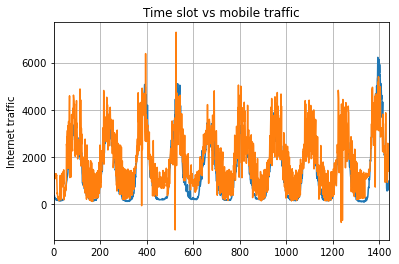

In [158]:
plt.title('Time slot vs mobile traffic')
plt.ylabel('Internet traffic')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(test)
plt.plot(x,predictions)
plt.show()

**Statistics of the test results.**

In [159]:
# Fraction of under-estimated demands
violated = (predictions < test)
violations = (test - predictions)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: 340 (23.61% of the test data points)


In [160]:
print('Demand mean:', np.mean(test))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(test)) )

Demand mean: 1470.0177488726144
Violation mean: 605.5795886107633
Violation excess: 41.20%


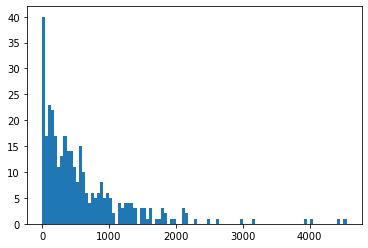

In [161]:
hist = plt.hist(violations, 100)

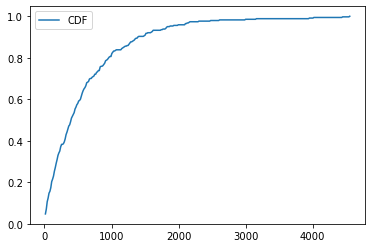

In [162]:
count, bins_count = np.histogram(violations, bins=len(violations))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

---
---
---

### 2. LSTM Multi-Node Prediction

**Preparing data.**

In [67]:
# Parameters
num_grids = 30
grids = [ grid for dmd, grid in max_dmd_grid[:num_grids] ]

In [68]:
datay = [ data[ data['grid'] == grid ] for grid in grids]

In [69]:
# Parameters
total_size = len(datay[0].index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 2880 Test size: 1440


In [70]:
# Train/test split
x = [ d['internet'].to_numpy() for d in datay ]
train = [ y[:train_size] for y in x ]
test = [ y[train_size:] for y in x ]

In [71]:
trainall = np.concatenate(train)
testall = np.concatenate(test)

In [72]:
# Normalized training data
scaler = [ MinMaxScaler(feature_range=(-1, 1)) for td in train ]
train_normalized = [  torch.FloatTensor(scaler[k].fit_transform(td.reshape(-1, 1))).view(-1).cuda() for k, td in enumerate(train) ]

In [73]:
# Create training sequences
train_seqs = [ create_inout_sequences(tn, tw = 144) for tn in train_normalized ]

In [74]:
train_seq = list(itertools.chain.from_iterable(train_seqs))

**Prepare model.**

In [75]:
model = LSTM()
model.cuda()  ### GPU training
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Training.**

In [76]:
epochs = 150

In [77]:
# t = time.time()
# for i in range(epochs):
#     for seq, labels in train_seq:
#         optimizer.zero_grad()
#         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
#                         torch.zeros(1, 1, model.hidden_layer_size).cuda())

#         y_pred = model(seq)

#         single_loss = loss_function(y_pred, labels)
#         single_loss.backward()
#         optimizer.step()

#     if i%25 == 0:
#         print(f'epoch: {i:3} loss: {single_loss.item():10.8f}\t time: {time.time()-t}')

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}\t time: {time.time()-t}')

In [78]:
# torch.save(model.state_dict(), 'lstm1-10node-lstm.model')

**Testing.**

In [79]:
# Load model
model = LSTM()
model.load_state_dict(torch.load('lstm1-10node-lstm.model'))

<All keys matched successfully>

In [80]:
tw = 144
test_inputs = [ tn[-tw:].tolist() for tn in train_normalized ]
test_normalized = [ torch.FloatTensor(scaler[k].fit_transform(tt.reshape(-1, 1))).view(-1).tolist() for k, tt in enumerate(test) ]

In [81]:
model.eval()
test_outputs = [ [] for _ in grids ]
for k, _ in enumerate(grids):
    for i in range(test_size):
        seq = torch.FloatTensor(test_inputs[k][-tw:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs[k].append(test_normalized[k].pop(0))
            test_outputs[k].append(model(seq).item())

lstm_out shape: torch.Size([144, 1, 100])
hidden_cell shape: (torch.Size([1, 1, 100]), torch.Size([1, 1, 100]))
predictions shape: torch.Size([144, 1])


In [82]:
predictions = [ scaler[k].inverse_transform(np.array(to).reshape(-1, 1)).reshape(test_size) for k, to in enumerate(test_outputs) ]
print(len(predictions[0]))

1440


In [83]:
x = np.arange(test_size)

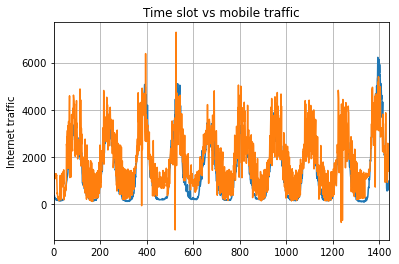

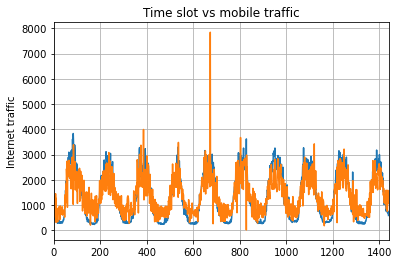

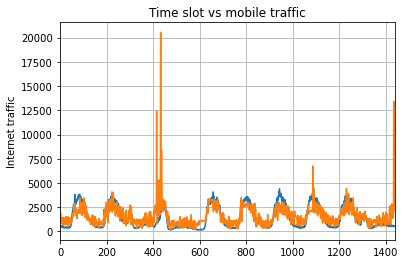

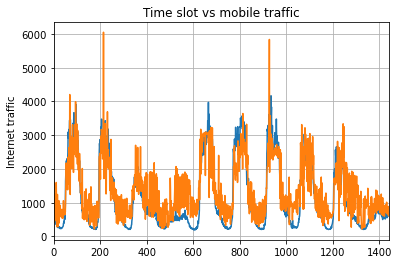

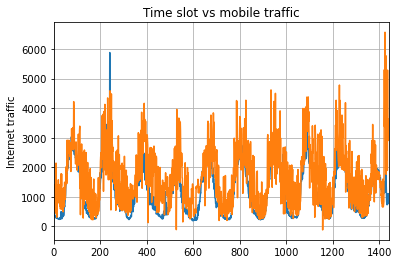

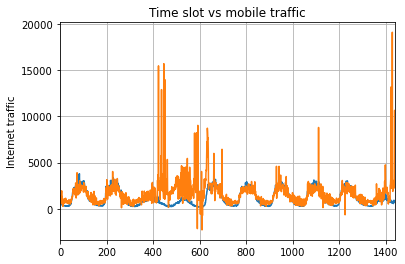

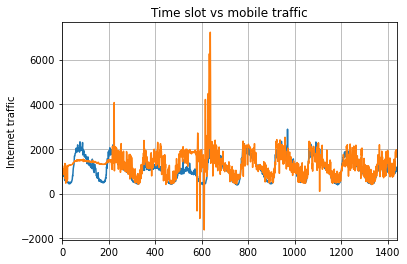

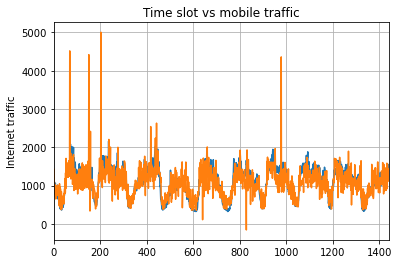

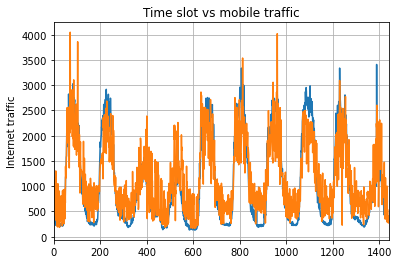

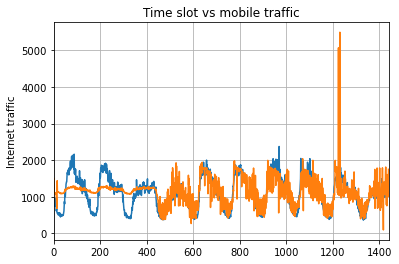

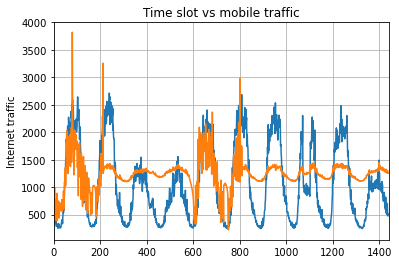

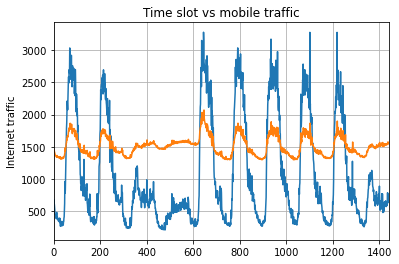

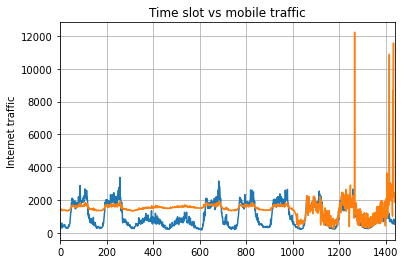

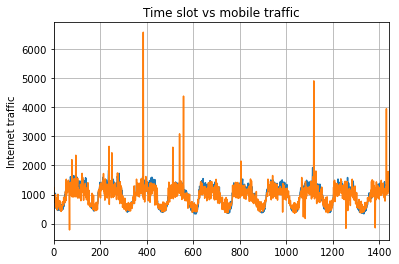

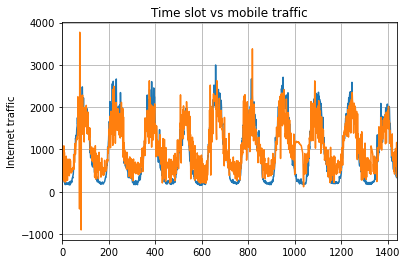

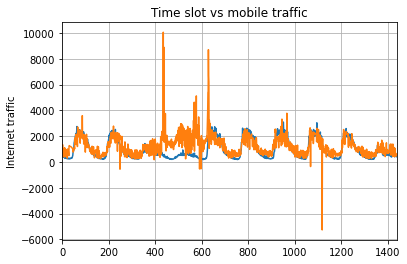

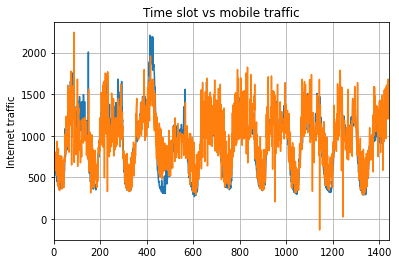

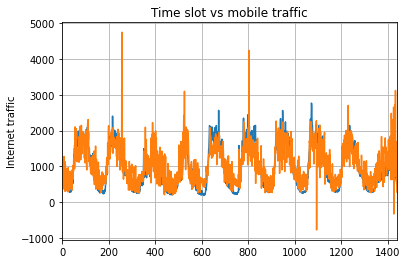

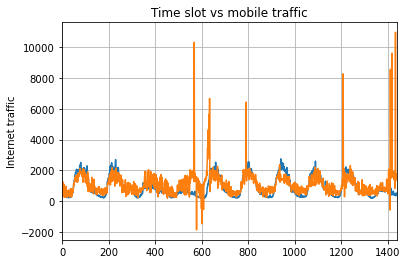

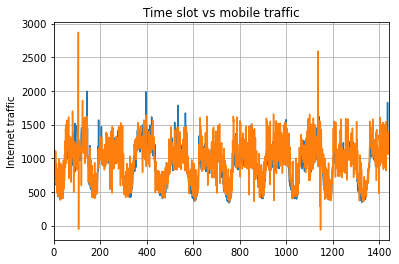

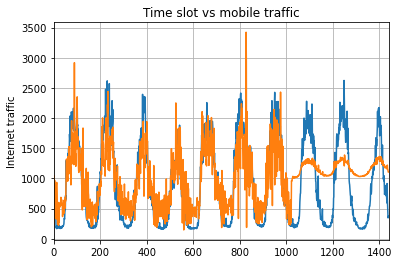

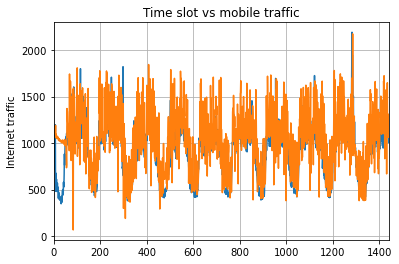

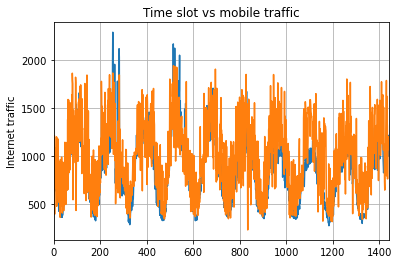

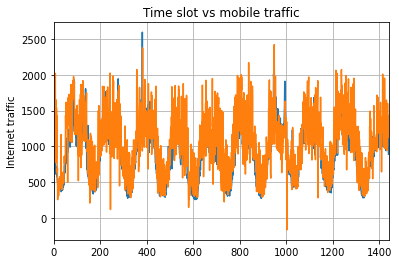

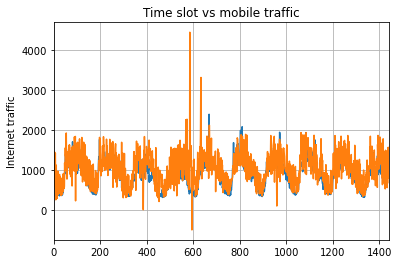

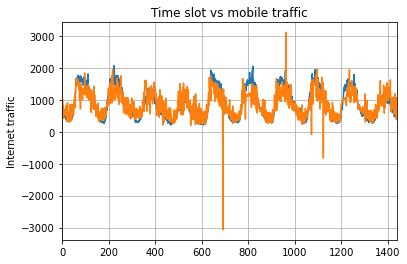

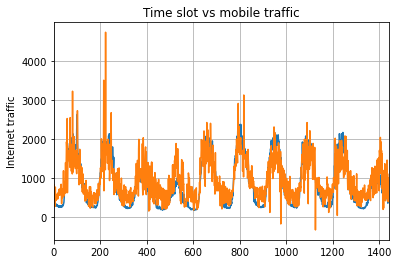

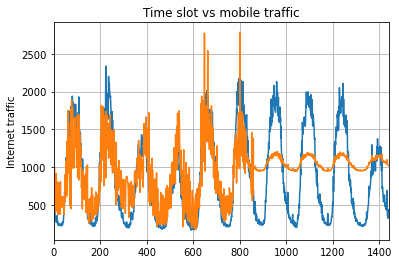

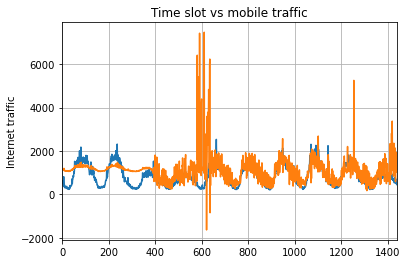

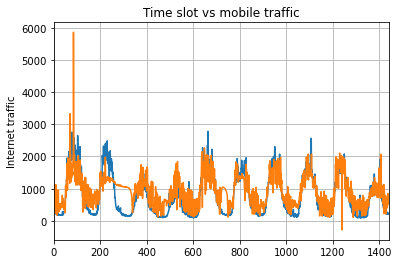

In [84]:
for k, _ in enumerate(grids):
    plt.title('Time slot vs mobile traffic')
    plt.ylabel('Internet traffic')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(test[k])
    plt.plot(x,predictions[k])
    plt.show()

**Statistics of the test results.**

In [85]:
# Fraction of under-estimated demands
violated = [ predictions[k] < test[k] for k, _ in enumerate(test) ]
violations = [ (test[i] - predictions[i])[violated[i]] for i, _ in enumerate(test) ]
print('Total violations:', sum([ sum(vio) for vio in violated ]), '(%.2f%% of the test data points)' % (100*sum([ sum(vio) for vio in violated ])/(test_size*len(grids))) )

Total violations: 14843 (34.36% of the test data points)


In [86]:
print('Demand mean:', [ np.mean( tt ) for tt in test ])
print('Violation mean:', [ np.mean( vio ) for vio in violations ] )
print('Violation excess:', [ '%.2f%%' % (100 * np.mean( violations[k] ) / np.mean(test[k])) for k, _ in enumerate(test) ] )

Demand mean: [1470.0177488726144, 1364.607922381596, 1417.201534351407, 1156.5556610027727, 1161.2742302021898, 1166.418592647613, 1130.1963305169713, 1119.833930089522, 1068.7914916656364, 1085.8375505991462, 1062.7258877886657, 1061.6154053147668, 1043.6070066413977, 1010.5449846777177, 981.7060473619572, 956.842680703662, 921.2867682013822, 966.7153571104477, 908.9121798168436, 908.308484868344, 924.3233539692624, 910.1028169299442, 837.6904553380239, 882.70113681151, 871.3852011901243, 866.8135798403507, 870.5833852693561, 867.0879725716294, 858.6191385967131, 779.1987981530601]
Violation mean: [605.5795886107633, 456.88092387609487, 616.7580845507924, 448.1415035307497, 339.1247258893673, 413.95665125930026, 260.7766497373961, 239.76347677440805, 410.20128910734303, 219.12253649854568, 523.7300001362188, 629.7547407428976, 312.97394006986616, 210.98207180407715, 313.27274091601186, 354.32279276697795, 182.70263642109697, 273.6430694578458, 329.01346653347684, 167.10988486076835, 3

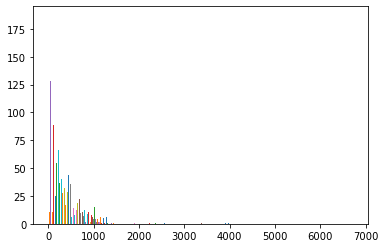

In [87]:
hist = plt.hist(violations, 100)

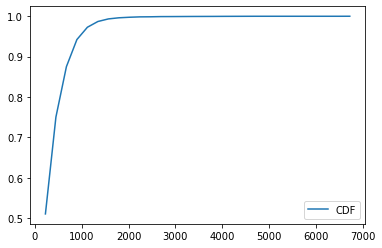

In [88]:
count, bins_count = np.histogram( np.concatenate(violations), bins=len(violations))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

---
---
---

### 3. **Robust** LSTM single grid prediction

**Preparing data.**

In [224]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [225]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 2880 Test size: 1440


In [226]:
# Train/test split
x = datax['internet'].to_numpy()
scaler = MinMaxScaler(feature_range=(0, 1))
x_normalized = scaler.fit_transform(x.reshape(-1, 1))
train = x_normalized[:train_size]
test = x_normalized[train_size:]

In [227]:
# Normalized training data
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_normalized = scaler.fit_transform(train.reshape(-1, 1))
# train_normalized = torch.FloatTensor(train_normalized).view(-1).cuda()
train_normalized = torch.FloatTensor(train).view(-1).cuda()

In [228]:
# Create training sequences
train_seq = create_inout_sequences(train_normalized, tw = 144)

**Constructing LSTM Model.**

In [229]:
model = LSTM()
model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [230]:
# sc = MinMaxScaler(feature_range=(0, 1))
# a = [1, 2, 3]
# b = [1,2,3,4,5]
# sc.fit_transform(np.array(a).reshape(-1, 1))
# sc.inverse_transform(np.array( [0.5, 1, 1.5] ).reshape(-1, 1))
# sc.transform(np.array(b).reshape(-1, 1))

**Customized loss function.**

In [231]:
def custom_loss(pred, target):
    loss = None
    
    return loss

**Training.**

In [232]:
epochs = 150
beta = torch.cuda.FloatTensor(1, device=torch.device('cuda')) * 10

In [233]:
# t = time.time()
# prev_loss = torch.ones(len(train_seq), device=torch.device('cuda'))
# prev_label_minus_y_pred = torch.ones(len(train_seq), device=torch.device('cuda'))
# prev_mean = (torch.ones(1, device=torch.device('cuda'))*beta).exp()
# prev_label_minus_y_pred_mean = (torch.zeros(1, device=torch.device('cuda'))*beta).exp()
# for i in range(epochs):
#     for j, (seq, labels) in enumerate(train_seq):
#         optimizer.zero_grad()
#         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=torch.device('cuda')),
#                         torch.zeros(1, 1, model.hidden_layer_size, device=torch.device('cuda')))
#         y_pred = model(seq)

#         single_loss = loss_function(y_pred, labels)
#         # >>> Compute weight loss
#         weight = torch.exp( beta * ( labels - y_pred ) ) / prev_label_minus_y_pred_mean # lstm6-7
#         #weight = torch.exp( beta * single_loss ) / prev_mean # lstm4-5
#         #weight = torch.exp( beta * (single_loss - prev_loss[j] ) )   # Expo diff loss: weight = exp( beta * (cur - last) ) # lstm3
#         #weight = np.clip(weight, 0.1, 10)
#         #print("i:", i, " prev:", prev_loss[i], " cur:", single_loss, " weight:", weight)
#         prev_loss[j] = single_loss.item()
#         prev_label_minus_y_pred[j] = ( labels - y_pred ).sum()
#         hooks = []
#         for name, param in model.named_parameters():
#             #print("Name:", name, " Weight:", weight)
#             h = param.register_hook(lambda grad: grad * weight)
#             hooks.append(h)
#         # <<< Compute weight loss
#         single_loss.backward()
#         optimizer.step()
        
#         # >>> Remove hooks
#         for h in hooks:
#             h.remove()
#         # <<< Remove hooks
        
#     # >>> Compute current iteration loss mean
#     prev_mean = (prev_loss*beta).exp().mean()
#     prev_label_minus_y_pred_mean = (prev_label_minus_y_pred*beta).exp().mean()
#     # <<< Compute current iteration loss mean

#     if i%25 == 0:
#         print(f'epoch: {i:3} loss: {single_loss.item():10.8f}\t time: {time.time()-t}')

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}\t time: {time.time()-t}')

In [234]:
# torch.save(model.state_dict(), 'lstm7-skewed-good-scalar.model')

**Testing.**

In [235]:
# Load model
model = LSTM()
model.load_state_dict(torch.load('lstm5-dro-expo-loss-0-1.model'))
#model.load_state_dict(torch.load('lstm.model'))

<All keys matched successfully>

In [236]:
tw = 144
test_inputs = train_normalized[-tw:].tolist()

In [237]:
test_normalized = torch.FloatTensor(test).view(-1).tolist()

In [238]:
test_normalized = scaler.fit_transform(test.reshape(-1, 1))
#test_normalized = torch.FloatTensor(scaler.fit_transform(test.reshape(-1, 1)).reshape(-1, 1)).view(-1).tolist()
test_normalized = torch.FloatTensor(test_normalized.reshape(-1, 1)).view(-1).tolist()

In [239]:
model.eval()
test_outputs = []
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-tw:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(test_normalized.pop(0))
        test_outputs.append(model(seq).item())

lstm_out shape: torch.Size([144, 1, 100])
hidden_cell shape: (torch.Size([1, 1, 100]), torch.Size([1, 1, 100]))
predictions shape: torch.Size([144, 1])


In [240]:
predictions = scaler.inverse_transform(np.array(test_outputs ).reshape(-1, 1)).reshape(test_size)
print(len(predictions))

1440


In [241]:
testdata = scaler.inverse_transform(np.array(test ).reshape(-1, 1)).reshape(test_size)

In [242]:
xdata = np.arange(test_size)

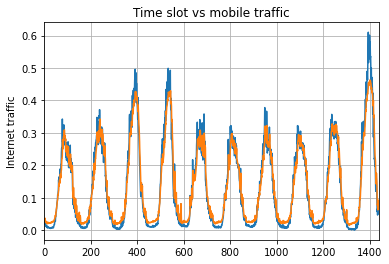

In [243]:
plt.title('Time slot vs mobile traffic')
plt.ylabel('Internet traffic')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(testdata)
plt.plot(xdata,predictions)
plt.show()

**Statistics of the test results.**

In [244]:
# Fraction of under-estimated demands
violated = (predictions < testdata)
violations = (testdata - predictions)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: 490 (34.03% of the test data points)


In [245]:
print('Demand mean:', np.mean(test))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(testdata)) )

Demand mean: 0.17432577759705875
Violation mean: 0.030346631905939753
Violation excess: 22.21%


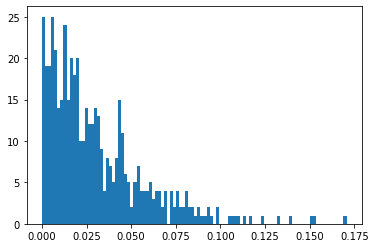

In [246]:
hist = plt.hist(violations, 100)

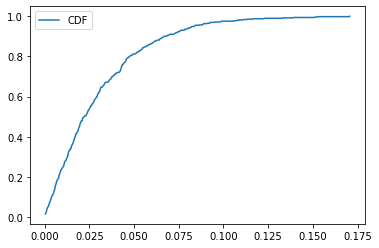

In [247]:
count, bins_count = np.histogram(violations, bins=len(violations))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

---
---
---

### 4. Facebook Prophet: Bayesian Regression

**Preparing data.**

In [113]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 2880 Test size: 1440


In [114]:
df = datax.copy()

In [115]:
df.rename(columns = {'time':'ds', 'internet':'y'}, inplace = True)

In [116]:
df['ds'] = pd.to_datetime(df['ds'], unit='ms')

In [117]:
# Train/test split
train = df.loc[:train_size]
test = df.loc[train_size:]

**Training.**

In [118]:
from prophet import Prophet
model = Prophet()

In [119]:
# t = time.time()
# model.fit(train)
# print("Training time:", time.time() - t)
# t = time.time()
# future = model.make_future_dataframe(periods=1)
# forecast = model.predict(future)
# print("Prediction time:", time.time() - t)

In [120]:
sys.stdout

**Testing.**

In [121]:
import warnings, io
warnings.filterwarnings('ignore')
import logging
logging.getLogger('prophet').setLevel(logging.WARNING) 

In [122]:
# test_inputs = []
# test_lower = []
# test_upper = []

# t = time.time()
# for ts in range(train_size, total_size):
#     train = df.loc[:ts]
#     model = Prophet()
#     stdo = sys.stdout
#     stde = sys.stderr
#     sys.stdout = io.StringIO()
#     sys.stderr = io.StringIO()
#     model.fit(train)
#     future = model.make_future_dataframe(periods=1)
#     forecast = model.predict(future)
#     foreval = forecast.iloc[-1]['yhat']
#     test_inputs.append(foreval)
#     test_lower.append(forecast.iloc[-1]['yhat_lower'])
#     test_upper.append(forecast.iloc[-1]['yhat_upper'])
    
#     sys.stdout = stdo
#     sys.stderr = stde
#     print("Data point:", ts - train_size + 1, " in ", time.time()-t, 's')

In [123]:
# dres = { 'test_inputs': test_inputs, 'test_lower': test_lower, 'test_upper': test_upper }
# with open("prophet.out", "w") as f:
#     f.write(json.dumps(dres, indent=4))    

**Showing results.**

In [124]:
with open("prophet.out", "r") as f:
    s = f.read()
    dres = json.loads(s)
    test_inputs = dres['test_inputs']
    test_lower = dres['test_lower']
    test_upper = dres['test_upper']

In [125]:
xdata = np.arange(test_size)

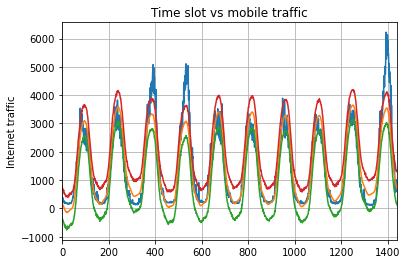

In [126]:
plt.title('Time slot vs mobile traffic')
plt.ylabel('Internet traffic')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(test['y'].tolist())
plt.plot(test_inputs)
plt.plot(test_lower)
plt.plot(test_upper)
plt.show()

In [127]:
testdata = np.array(test['y'].tolist())
predictions = np.array(test_inputs)
pred_upper = np.array(test_upper)

In [128]:
sys.stdout

**Statistics of the test results.**

In [129]:
# Fraction of under-estimated demands
violated = (pred_upper < testdata)
violations = (testdata - pred_upper)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: 120 (8.33% of the test data points)


In [130]:
print('Demand mean:', np.mean(testdata))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(testdata)) )

Demand mean: 1470.0177488726144
Violation mean: 703.2052579065353
Violation excess: 47.84%


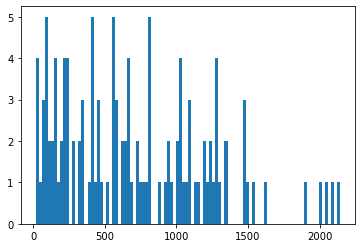

In [131]:
hist = plt.hist(violations, 100)

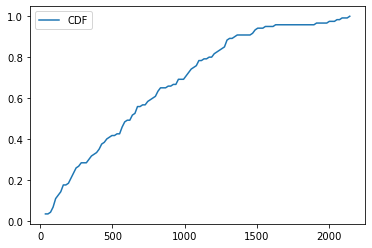

In [132]:
count, bins_count = np.histogram(violations, bins=len(violations))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

In [133]:
train = df.loc[:2880]
model = Prophet()
stdo = sys.stdout
stde = sys.stderr
sys.stdout = io.StringIO()
sys.stderr = io.StringIO()
model.fit(train)
future = model.make_future_dataframe(periods=300, freq='H')
forecast = model.predict(future)
foreval = forecast.iloc[-1]['yhat']
sys.stdout = stdo
sys.stderr = stde

Initial log joint probability = -64.1262
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6880.37   3.28629e-05       101.644      0.4729      0.4729      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6881.93   8.83528e-06       67.7907           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       6881.94   1.14161e-05       79.3527   1.774e-07       0.001      297  LS failed, Hessian reset 
     213       6881.94   1.99183e-07       52.8454      0.4156      0.4156      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [134]:
model.mcmc_samples

0

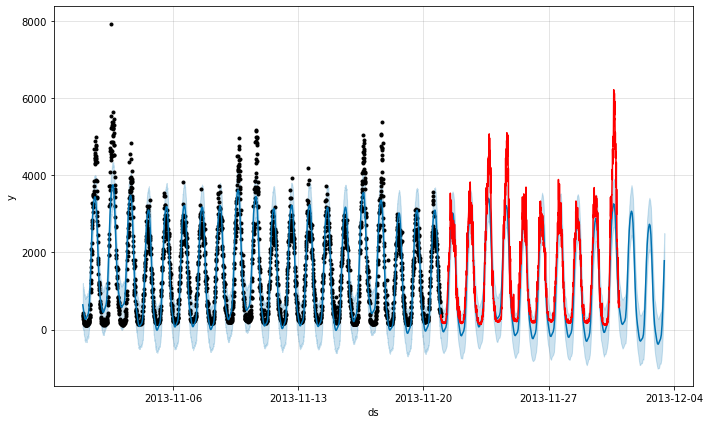

In [135]:
forecast.head()
fig1 = model.plot(forecast)
plt.plot(test['ds'], test['y'].tolist(), 'r')

In [136]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-10-31 23:00:00,1695.078385,41.250753,1196.953114,1695.078385,1695.078385,-1055.060000,-1055.060000,-1055.060000,-923.203910,-923.203910,-923.203910,-131.856091,-131.856091,-131.856091,0.0,0.0,0.0,640.018385
1,2013-10-31 23:10:00,1694.692423,92.977021,1208.501888,1694.692423,1694.692423,-1078.810159,-1078.810159,-1078.810159,-946.440519,-946.440519,-946.440519,-132.369640,-132.369640,-132.369640,0.0,0.0,0.0,615.882264
2,2013-10-31 23:20:00,1694.306461,35.836837,1147.872252,1694.306461,1694.306461,-1102.083239,-1102.083239,-1102.083239,-969.213230,-969.213230,-969.213230,-132.870010,-132.870010,-132.870010,0.0,0.0,0.0,592.223221
3,2013-10-31 23:30:00,1693.920499,7.374631,1080.646452,1693.920499,1693.920499,-1125.070076,-1125.070076,-1125.070076,-991.713221,-991.713221,-991.713221,-133.356856,-133.356856,-133.356856,0.0,0.0,0.0,568.850422
4,2013-10-31 23:40:00,1693.534536,-15.435033,1117.098408,1693.534536,1693.534536,-1147.900143,-1147.900143,-1147.900143,-1014.070310,-1014.070310,-1014.070310,-133.829833,-133.829833,-133.829833,0.0,0.0,0.0,545.634393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,2013-12-03 07:00:00,1027.463292,-784.595894,470.461169,683.745672,1381.821251,-1164.002361,-1164.002361,-1164.002361,-1054.135817,-1054.135817,-1054.135817,-109.866544,-109.866544,-109.866544,0.0,0.0,0.0,-136.539069
3177,2013-12-03 08:00:00,1026.610127,-532.659310,805.194737,681.164530,1382.438026,-900.837302,-900.837302,-900.837302,-796.191404,-796.191404,-796.191404,-104.645898,-104.645898,-104.645898,0.0,0.0,0.0,125.772824
3178,2013-12-03 09:00:00,1025.756961,-83.797901,1247.655358,678.844727,1383.065393,-434.858399,-434.858399,-434.858399,-335.260227,-335.260227,-335.260227,-99.598171,-99.598171,-99.598171,0.0,0.0,0.0,590.898562
3179,2013-12-03 10:00:00,1024.903796,538.868388,1896.830379,676.524923,1383.433431,166.528313,166.528313,166.528313,261.289575,261.289575,261.289575,-94.761262,-94.761262,-94.761262,0.0,0.0,0.0,1191.432109


---
---
---


### ?. CNN-LSTM Global Prediction

**Preparing data.**

In [137]:
# # Parameters
# timeslots = sorted(data['time'].unique())
# total_size = len(timeslots)
# train_size = int(total_size * 2 / 3)
# test_size = total_size - train_size
# print("Train size:", train_size, "Test size:", test_size)

In [138]:
# # Train/test split
# x = [ data[ data['time'] == time ]['internet'].tolist() for time in timeslots ]
# train = x[:train_size]
# test = x[train_size:]

In [139]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniformly 